<h1 align="center"><b>AgriYield Predictor</b></h1>
<h2 align="center"> - Manju Varshikha S </h2>


LIBRARIES

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
print("Libraries imported successfully.")

Libraries imported successfully.


LOAD DATASETS

In [68]:
fao_df = pd.read_csv("data/FAOSTAT_data_en_11-18-2025.csv")
crop_df = pd.read_csv("data/Crop_recommendation.csv")
print("\nFAOSTAT Dataset:")
fao_df.head()
print("Shape:", fao_df.shape)

print("\nCrop Label Dataset:")
crop_df.head()
print("Shape:", crop_df.shape)


FAOSTAT Dataset:
Shape: (4996, 15)

Crop Label Dataset:
Shape: (2200, 8)


CLEAN & SPLIT FAO ITEM COLUMN

In [69]:
fao_df["Item"] = fao_df["Item"].str.split(r",|and")
fao_df = fao_df.explode("Item")
fao_df["Item"] = fao_df["Item"].str.strip()

STANDARDIZE CROP NAMES (MAPPING)

In [70]:
crop_mapping = {
    "Rice": "rice",
    "Maize (corn)": "maize",
    "Chick peas": "chickpea",
    "Pigeon peas": "pigeonpeas",
    "Lentils": "lentil",
    "Beans": "mothbeans",
    "Bananas": "banana",
    "Mangoes": "mango",
    "Grapes": "grapes",
    "Watermelons": "watermelon",
    "Cantaloupes": "muskmelon",
    "Apples": "apple",
    "Oranges": "orange",
    "Papayas": "papaya",
    "Coconuts": "coconut",
    "Seed cotton": "cotton",
    "Jute": "jute",
    "Coffee": "coffee"
}

fao_df["Crop"] = fao_df["Item"].map(crop_mapping)

In [71]:
crop_df = crop_df.rename(columns={'label': 'Crop'})
crop_df.head()

,N,P,K,temperature,humidity,ph,rainfall,Crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


Merging datasets

In [72]:
merged_df = crop_df.merge(
    fao_df,
    on="Crop",
    how="inner"
)

merged_df = merged_df[merged_df["Element"] == "Production"]
merged_df.head()

,N,P,K,temperature,humidity,ph,rainfall,Crop,Domain Code,Domain,...,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
2,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,QCL,Crops and livestock products,...,Production,0113,Rice,2005,2005,t,137690096.0,A,Official figure,NaN
5,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,QCL,Crops and livestock products,...,Production,0113,Rice,2006,2006,t,139136992.0,A,Official figure,NaN
8,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,QCL,Crops and livestock products,...,Production,0113,Rice,2007,2007,t,144570000.0,A,Official figure,NaN
11,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,QCL,Crops and livestock products,...,Production,0113,Rice,2008,2008,t,148036000.0,A,Official figure,NaN
14,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,QCL,Crops and livestock products,...,Production,0113,Rice,2009,2009,t,135672992.0,A,Official figure,NaN


DROP IRRELEVANT COLUMNS

In [73]:
merged_df = merged_df.drop(columns=[
    'Domain Code','Domain','Area Code (M49)','Area',
    'Element Code','Element','Item Code (CPC)','Item',
    'Year','Year Code','Unit','Flag','Flag Description','Note'
])

Missing value and duplicate checks

In [74]:
print("Missing Values:\n", merged_df.isnull().sum())
print("\nDuplicate Rows:", merged_df.duplicated().sum())

merged_df = merged_df.drop_duplicates().reset_index(drop=True)

Missing Values:
 N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
Crop           0
Value          0
dtype: int64

Duplicate Rows: 500


Summary Statistics

In [75]:
merged_df.describe()
merged_df.nunique()

N               136
P               117
K                73
temperature    1800
humidity       1800
ph             1800
rainfall       1800
Crop             18
Value           337
dtype: int64

SHOW UNIQUE CROPS 

In [76]:
print("Total Unique Crops:", merged_df["Crop"].nunique())
print("\nAvailable Crops:\n")

for i, crop in enumerate(sorted(merged_df["Crop"].unique()), start=1):
    print(f"{i}. {crop.capitalize()}")

Total Unique Crops: 18

Available Crops:

1. Apple
2. Banana
3. Chickpea
4. Coconut
5. Coffee
6. Cotton
7. Grapes
8. Jute
9. Lentil
10. Maize
11. Mango
12. Mothbeans
13. Muskmelon
14. Orange
15. Papaya
16. Pigeonpeas
17. Rice
18. Watermelon


CROP DISTRIBUTION

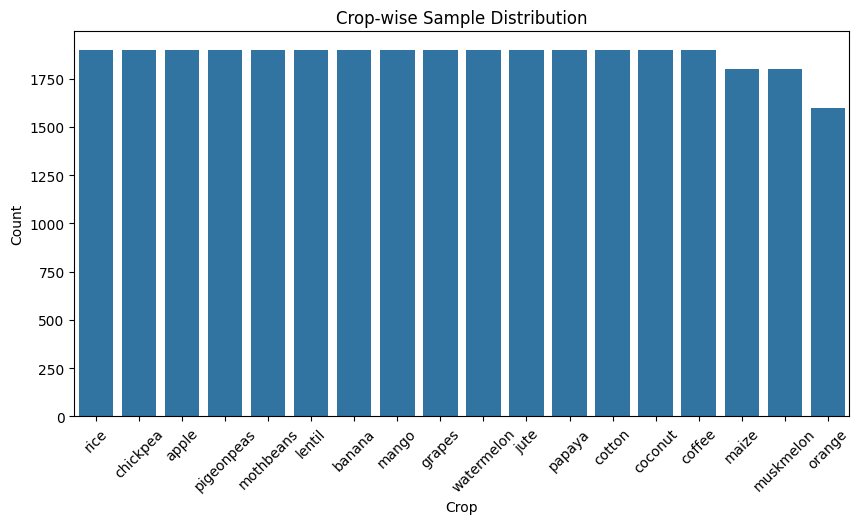

In [77]:
crop_distribution = merged_df["Crop"].value_counts()
crop_distribution
plt.figure(figsize=(10,5))
sns.barplot(x=crop_distribution.index, y=crop_distribution.values)
plt.xticks(rotation=45)
plt.title("Crop-wise Sample Distribution")
plt.ylabel("Count")
plt.show()


OUTLIER REMOVAL USING IQR

In [78]:
numeric_cols = ["N","P","K","temperature","humidity","ph","rainfall","Value"]

Q1 = merged_df[numeric_cols].quantile(0.25)
Q3 = merged_df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

clean_df = merged_df[
    ~((merged_df[numeric_cols] < (Q1 - 1.5 * IQR)) |
      (merged_df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
]

print("Before:", merged_df.shape)
print("After :", clean_df.shape)

Before: (33700, 9)
After : (24945, 9)


CORRELATION HEATMAP

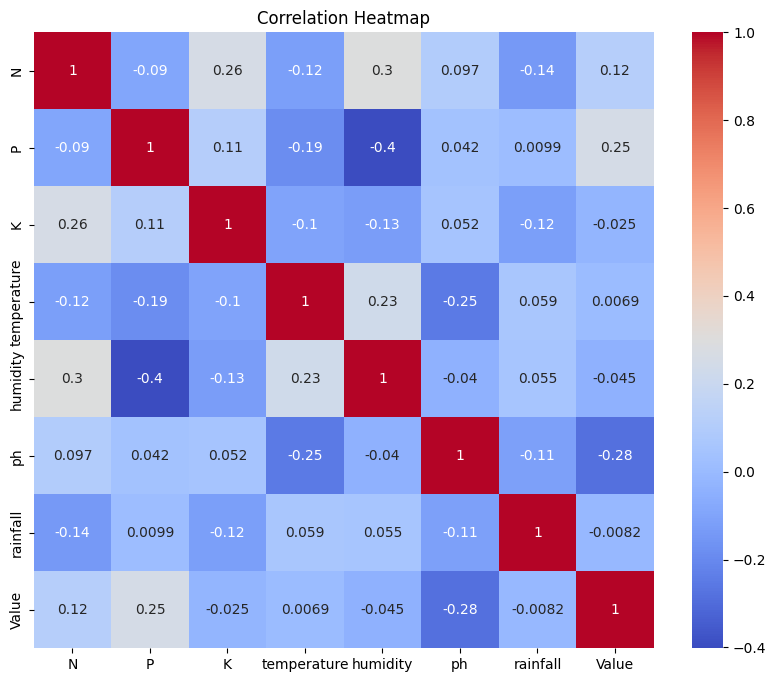

In [79]:
plt.figure(figsize=(10,8))
sns.heatmap(clean_df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

FEATURE ENGINEERING

In [80]:
X = clean_df.drop(columns="Value")
y = clean_df["Value"]

X = pd.get_dummies(X, columns=["Crop"], drop_first=False)


TRAIN TEST SPLIT

SHOW CROPS AFTER ENCODING (MODEL VIEW)

In [81]:
encoded_crops = [c.replace("Crop_", "") for c in X.columns if c.startswith("Crop_")]

print("Encoded Crops Used by Model:\n")
for i, c in enumerate(sorted(encoded_crops), start=1):
    print(f"{i}. {c.capitalize()}")

Encoded Crops Used by Model:

1. Banana
2. Chickpea
3. Coconut
4. Coffee
5. Cotton
6. Jute
7. Lentil
8. Maize
9. Mango
10. Mothbeans
11. Muskmelon
12. Orange
13. Papaya
14. Pigeonpeas
15. Watermelon


TRAIN–TEST SPLIT

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape)
print("Test :", X_test.shape)

Train: (19956, 22)
Test : (4989, 22)


EVALUATION FUNCTION

In [83]:
def evaluate_model(name, y_tr, y_tr_pred, y_te, y_te_pred):
    return {
        "Model": name,
        "Train_R2": r2_score(y_tr, y_tr_pred),
        "Test_R2": r2_score(y_te, y_te_pred),
        "Train_MAE": mean_absolute_error(y_tr, y_tr_pred),
        "Test_MAE": mean_absolute_error(y_te, y_te_pred),
        "Train_RMSE": np.sqrt(mean_squared_error(y_tr, y_tr_pred)),
        "Test_RMSE": np.sqrt(mean_squared_error(y_te, y_te_pred))
    }

Model Training

In [84]:
results = []

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
results.append(evaluate_model(
    "Linear Regression",
    y_train, lr.predict(X_train),
    y_test, lr.predict(X_test)
))

# Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
results.append(evaluate_model(
    "Ridge Regression",
    y_train, ridge.predict(X_train),
    y_test, ridge.predict(X_test)
))

# Lasso
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
results.append(evaluate_model(
    "Lasso Regression",
    y_train, lasso.predict(X_train),
    y_test, lasso.predict(X_test)
))

# Decision Tree
dt = DecisionTreeRegressor(max_depth=12, random_state=42)
dt.fit(X_train, y_train)
results.append(evaluate_model(
    "Decision Tree",
    y_train, dt.predict(X_train),
    y_test, dt.predict(X_test)
))

# Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
results.append(evaluate_model(
    "Random Forest",
    y_train, rf.predict(X_train),
    y_test, rf.predict(X_test)
))

# XGBoost
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42
)
xgb.fit(X_train, y_train)
results.append(evaluate_model(
    "XGBoost",
    y_train, xgb.predict(X_train),
    y_test, xgb.predict(X_test)
))

c:\Users\manju varshikha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.173e+15, tolerance: 1.686e+14
  model = cd_fast.enet_coordinate_descent(


FINAL RESULTS TABLE

In [85]:
results_df = pd.DataFrame(results)
results_df

,Model,Train_R2,Test_R2,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE
0,Linear Regression,0.925799,0.927288,1.520630e+06,1.540680e+06,2.504096e+06,2.494018e+06
1,Ridge Regression,0.925798,0.927293,1.520923e+06,1.540791e+06,2.504114e+06,2.493931e+06
2,Lasso Regression,0.925799,0.927288,1.520630e+06,1.540680e+06,2.504096e+06,2.494018e+06
3,Decision Tree,0.926739,0.918622,1.511330e+06,1.612935e+06,2.488184e+06,2.638443e+06
4,Random Forest,0.926816,0.917561,1.508549e+06,1.633779e+06,2.486864e+06,2.655594e+06
5,XGBoost,0.926730,0.919228,1.514002e+06,1.611424e+06,2.488332e+06,2.628603e+06


TRAIN vs TEST ACCURACY PLOT

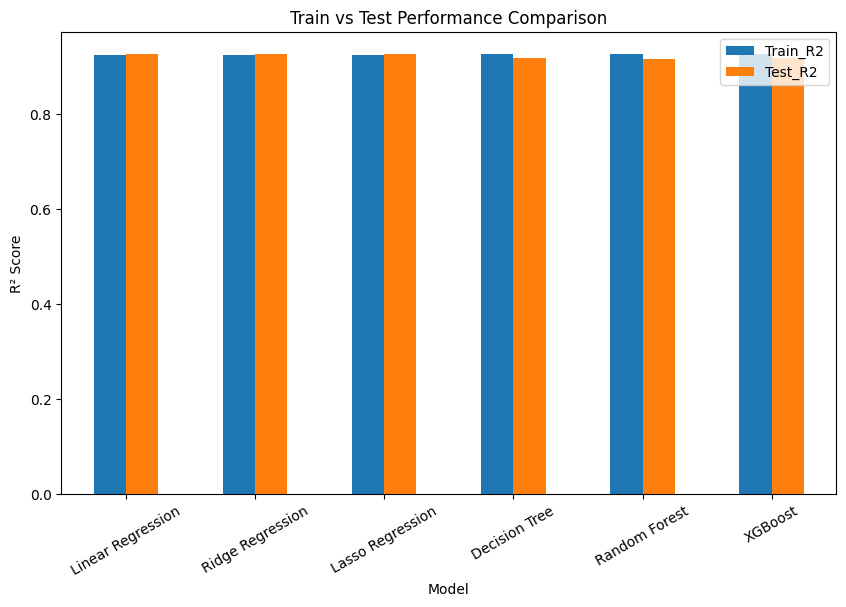

In [86]:
results_df.set_index("Model")[["Train_R2","Test_R2"]].plot(
    kind="bar", figsize=(10,6)
)
plt.ylabel("R² Score")
plt.title("Train vs Test Performance Comparison")
plt.xticks(rotation=30)
plt.show()

BEST MODEL RESIDUAL ANALYSIS (XGBOOST)

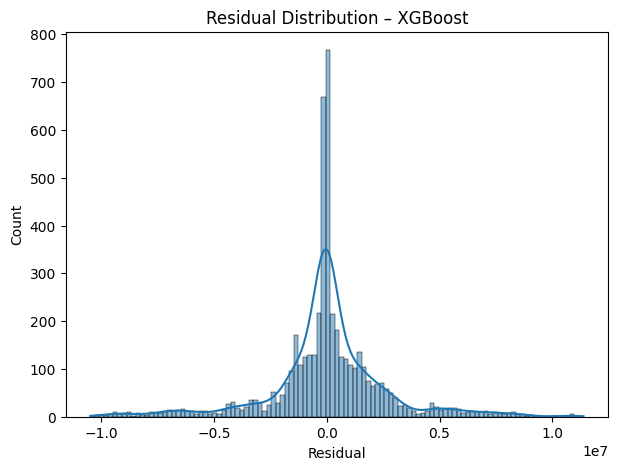

In [87]:
residuals = y_test - xgb.predict(X_test)

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution – XGBoost")
plt.xlabel("Residual")
plt.show()